In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.autograd import Variable
from scipy.io import wavfile
import matplotlib.pyplot as plt
from PIL import Image
import io

c:\Users\hp\Downloads\lm\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data transformations
def get_data_loaders(data_root, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    dataset = ImageFolder(root=data_root, transform=transform)

    train_size = int(0.80 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader,dataset

In [3]:
# Neural network model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 16 * 16, num_classes)  # Adjust the input size
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        return x

In [4]:
# Training and evaluation functions
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        correct_predictions += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            correct_predictions += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [5]:
# Training loop with added plotting
def train_loop_with_plotting(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        scheduler.step()  # Step the learning rate scheduler

        # Append losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print training and validation results for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

    # Plotting
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/20], Training Loss: 2.2938, Training Accuracy: 0.34, Validation Loss: 1.5752, Validation Accuracy: 0.46
Epoch [2/20], Training Loss: 1.5628, Training Accuracy: 0.43, Validation Loss: 1.2680, Validation Accuracy: 0.27
Epoch [3/20], Training Loss: 1.3168, Training Accuracy: 0.52, Validation Loss: 0.9432, Validation Accuracy: 0.61
Epoch [4/20], Training Loss: 1.2530, Training Accuracy: 0.53, Validation Loss: 0.7723, Validation Accuracy: 0.63
Epoch [5/20], Training Loss: 1.1362, Training Accuracy: 0.54, Validation Loss: 0.7063, Validation Accuracy: 0.70
Epoch [6/20], Training Loss: 1.0422, Training Accuracy: 0.57, Validation Loss: 0.6836, Validation Accuracy: 0.70
Epoch [7/20], Training Loss: 1.0252, Training Accuracy: 0.59, Validation Loss: 0.7615, Validation Accuracy: 0.59
Epoch [8/20], Training Loss: 1.0091, Training Accuracy: 0.57, Validation Loss: 0.6799, Validation Accuracy: 0.68
Epoch [9/20], Training Loss: 0.8654, Training Accuracy: 0.66, Validation Loss: 0.6172, Validatio

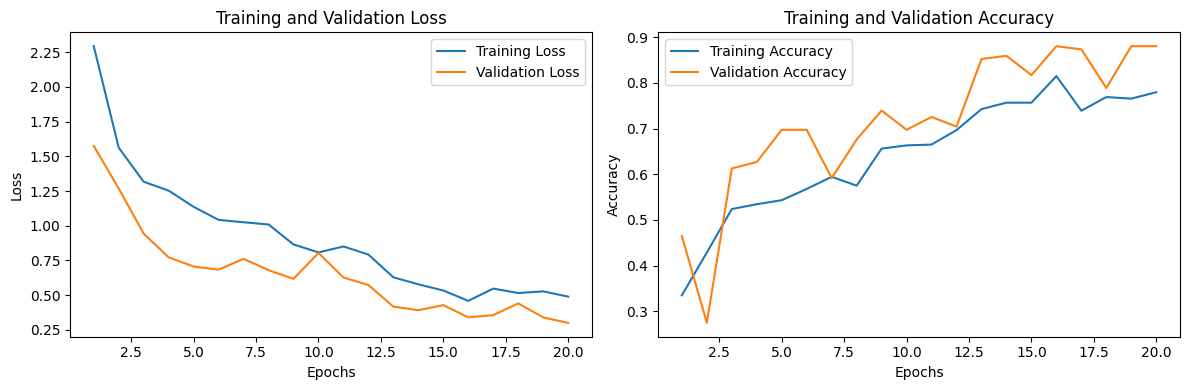

In [6]:
data_root = 'Spectrograms - Copy'
train_loader, val_loader,dataset = get_data_loaders(data_root)

model = SimpleCNN(num_classes=9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

num_epochs = 20
train_loop_with_plotting(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

## Predicts the class of the audio files

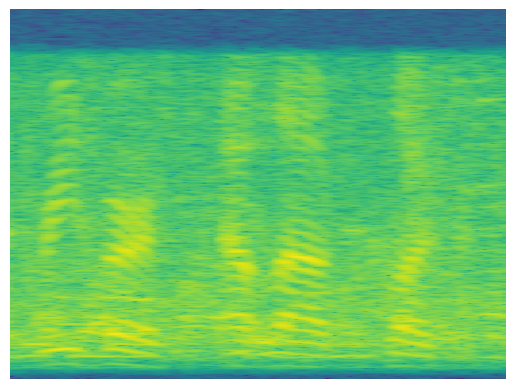

The predicted class is: Restaurant


In [14]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class AudioDataset(Dataset):
    def __init__(self, audio_file, transform=None):
        self.audio_file = audio_file
        self.transform = transform

    def __len__(self):
        return 1  # Since we have only one audio file

    def __getitem__(self, idx):
        sample_rate, audio_data = wavfile.read(self.audio_file)
        return audio_data, sample_rate

# Function to generate and show spectrogram image
def generate_and_show_spectrogram(audio_data, sample_rate):
    plt.specgram(audio_data, NFFT=1024, Fs=sample_rate, noverlap=900)
    plt.axis('off')
    plt.show()

# Function to make prediction
def predict_class(model, image, transform):
    image_tensor = transform(image)
    image_tensor = Variable(image_tensor.unsqueeze(0))
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    probabilities = nn.Softmax(dim=1)(outputs)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    return predicted_class

# Main part
if __name__ == "__main__":
    audio_file = 'Data/Audio/Noizeus/Restaurant/sp04_restaurant_sn5.wav'
    
    # Load the audio data
    audio_dataset = AudioDataset(audio_file, transform=None)
    audio_data, sample_rate = audio_dataset[0]

    # Generate and show spectrogram image
    generate_and_show_spectrogram(audio_data, sample_rate)

    # Make prediction (you may want to modify this part based on how you get the model and dataset)
    image_tensor = transform(Image.fromarray(audio_data).convert('RGB'))
    image_tensor = Variable(image_tensor.unsqueeze(0))
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    probabilities = nn.Softmax(dim=1)(outputs)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Get the class label
    class_label = dataset.classes[predicted_class]

    print(f'The predicted class is: {class_label}')


In [8]:
torch.save(model.state_dict(), 'model/voice.pth')